In [1]:
import os
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


In [2]:
#check cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using CUDA!")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU!")

GPU is available. Using CUDA!


In [3]:
#metrics
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * log10(1.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True)

In [4]:
#utils
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device,weights_only=True))
    return model

def display_images(images, titles=None):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [ ]:
class DeblurDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform or transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor()
        ])

        self.blur_paths = []
        self.sharp_paths = []

        for subdir, dirs, files in os.walk(root_dir):
            if os.path.basename(subdir) == "blur":
                for fname in sorted(os.listdir(subdir)):
                    blur_path = os.path.join(subdir, fname)
                    sharp_path = blur_path.replace('blur', 'sharp')
                    if os.path.exists(sharp_path):
                        self.blur_paths.append(blur_path)
                        self.sharp_paths.append(sharp_path)

    
    def __len__(self):
        return len(self.blur_paths)

    def __getitem__(self, idx):
        blur_img = Image.open(self.blur_paths[idx]).convert("RGB")
        sharp_img = Image.open(self.sharp_paths[idx]).convert("RGB")

        if self.transform:
            blur_img = self.transform(blur_img)
            sharp_img = self.transform(sharp_img)

        return blur_img, sharp_img

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, num_residual_blocks=6):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.bottleneck = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residual_blocks)]
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        bottleneck = self.bottleneck(encoded)
        decoded = self.decoder(bottleneck)
        return decoded

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0), 
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)  
        return validity.view(-1, 1)  

In [10]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(42)
torch.manual_seed(42)
generator = Generator()
discriminator = Discriminator()

if torch.cuda.device_count() > 1:
    print(f"🖥️ Using {torch.cuda.device_count()} GPUs!")
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

generator = generator.to(device)
discriminator = discriminator.to(device)

train_dataset = DeblurDataset(root_dir='/kaggle/input/gopro/GOPRO_Large/train')
test_dataset = DeblurDataset(root_dir='/kaggle/input/gopro/GOPRO_Large/test')  

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

adversarial_loss = nn.BCEWithLogitsLoss()
pixel_loss = nn.L1Loss()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

training_losses = []
num_epochs = 95
best_checkpoint_generator = None
lowest_train_loss = float("inf")

for epoch in range(num_epochs):
    import time
    start_time = time.time()
    generator.train()
    train_loss = 0

    for i, (blurred, sharp) in enumerate(train_loader):
        blurred, sharp = blurred.to(device), sharp.to(device)

        real_output = discriminator(sharp)
        fake_images = generator(blurred)
        fake_output = discriminator(fake_images.detach())

        real_labels = torch.ones_like(real_output, device=device)
        fake_labels = torch.zeros_like(fake_output, device=device)

        d_optimizer.zero_grad()
        d_loss = (adversarial_loss(real_output, real_labels) +
                  adversarial_loss(fake_output, fake_labels)) / 2
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()
        fake_output = discriminator(fake_images)
        g_adv_loss = adversarial_loss(fake_output, real_labels)
        g_pix_loss = pixel_loss(fake_images, sharp)
        g_loss = g_adv_loss + 100 * g_pix_loss
        g_loss.backward()
        g_optimizer.step()

        train_loss += g_loss.item()

        if i % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    epoch_loss = train_loss / len(train_loader)
    training_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    end_time = time.time()  
    elapsed_time = (end_time - start_time) / 60  
    print(f"1 epoch time: {elapsed_time}")

    checkpoint_generator = f"/kaggle/working/generatorepoch{epoch+1}.pth"
    torch.save(generator.state_dict(), checkpoint_generator)

    checkpoint_discriminator = f"/kaggle/working/discriminatorepoch{epoch+1}.pth"
    torch.save(discriminator.state_dict(), checkpoint_discriminator)
    
    if epoch_loss < lowest_train_loss:
        lowest_train_loss = epoch_loss
        best_checkpoint_generator = checkpoint_generator
        best_checkpoint_discriminator = checkpoint_discriminator

print("Training complete!")
print(f"Best generator checkpoint: {best_checkpoint_generator} with Training Loss: {lowest_train_loss:.4f}")
print(f"Best discriminator checkpoint: {best_checkpoint_discriminator}")

🖥️ Using 2 GPUs!


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/95], Step [1/132], D Loss: 0.7181, G Loss: 46.9652
Epoch [1/95], Step [6/132], D Loss: 0.7024, G Loss: 11.1761
Epoch [1/95], Step [11/132], D Loss: 0.6907, G Loss: 9.7001
Epoch [1/95], Step [16/132], D Loss: 0.6839, G Loss: 9.1794
Epoch [1/95], Step [21/132], D Loss: 0.6781, G Loss: 6.7094
Epoch [1/95], Step [26/132], D Loss: 0.6684, G Loss: 6.8438
Epoch [1/95], Step [31/132], D Loss: 0.6406, G Loss: 6.4299
Epoch [1/95], Step [36/132], D Loss: 0.6667, G Loss: 6.2258
Epoch [1/95], Step [41/132], D Loss: 0.5764, G Loss: 6.6782
Epoch [1/95], Step [46/132], D Loss: 0.6304, G Loss: 8.0384
Epoch [1/95], Step [51/132], D Loss: 0.6444, G Loss: 10.2530
Epoch [1/95], Step [56/132], D Loss: 0.6188, G Loss: 6.1273
Epoch [1/95], Step [61/132], D Loss: 0.6223, G Loss: 6.5601
Epoch [1/95], Step [66/132], D Loss: 0.6731, G Loss: 6.4315
Epoch [1/95], Step [71/132], D Loss: 0.6560, G Loss: 5.8938
Epoch [1/95], Step [76/132], D Loss: 0.6465, G Loss: 6.0217
Epoch [1/95], Step [81/132], D Loss: 0.

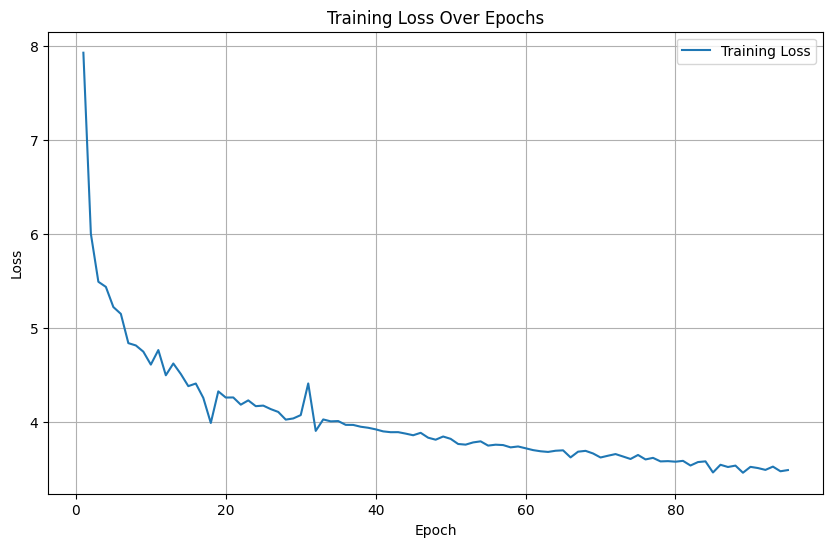

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.savefig("training_loss_plot.png")


In [ ]:
generator = Generator()
if torch.cuda.device_count() > 1:
    generator = nn.DataParallel(generator)
generator = generator.to(device)
generator.load_state_dict(torch.load(best_checkpoint_generator, map_location=device))
generator.eval()

from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_ssim(img1, img2, win_size=7):
    return ssim(img1, img2, channel_axis=2, win_size=win_size, data_range=1.0)

total_psnr = 0.0
total_ssim = 0.0
count = 0

for blurred, sharp in test_loader:
    blurred = blurred.to(device)
    sharp = sharp.to(device)

    with torch.no_grad():
        output = generator(blurred)

    output_resized = np.transpose(output.cpu().numpy()[0], (1, 2, 0))
    sharp_resized = np.transpose(sharp.cpu().numpy()[0], (1, 2, 0))
    output_resized = np.clip(output_resized, 0, 1)
    sharp_resized = np.clip(sharp_resized, 0, 1)

    psnr_val = calculate_psnr(output_resized, sharp_resized)
    win_size = min(11, min(output_resized.shape[0], output_resized.shape[1]) - 1)
    ssim_val = calculate_ssim(output_resized, sharp_resized, win_size=win_size)

    total_psnr += psnr_val
    total_ssim += ssim_val
    count += 1

print(f"Average PSNR: {total_psnr / count:.2f}")
print(f"Average SSIM: {total_ssim / count:.4f}")


/tmp/ipykernel_23/2905787750.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(best_checkpoint_generator, map_location=device))


Average PSNR: 27.24
Average SSIM: 0.8568


In [ ]:

import torch
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator()
if torch.cuda.device_count() > 1:
    generator = torch.nn.DataParallel(generator)
generator = generator.to(device)

best_checkpoint_path = best_checkpoint_generator  
generator.load_state_dict(torch.load(best_checkpoint_path, map_location=device))
generator.eval()

transform = transforms.Compose([
    transforms.Resize((360, 640)),  
    transforms.ToTensor()
])

img_path = "/kaggle/input/gopro/GOPRO_Large/test/GOPR0384_11_00/blur/000001.png"
img = Image.open(img_path).convert("RGB")

input_tensor = transform(img).unsqueeze(0).to(device)  

with torch.no_grad():
    output_tensor = generator(input_tensor)

output_tensor = output_tensor.squeeze(0).cpu()  
output_img = transforms.ToPILImage()(output_tensor.clamp(0, 1))

output_img.save("deblurred_output.png")
output_img.show()  

/tmp/ipykernel_23/1019843964.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(best_checkpoint_path, map_location=device))


In [ ]:
input_for_show = transforms.ToTensor()(img.resize((640, 360)))
input_for_show = input_for_show * 0.5 + 0.5

input_img = transforms.ToPILImage()(input_for_show)
combined = Image.new('RGB', (640 * 2, 360))
combined.paste(input_img, (0, 0))
combined.paste(output_img, (640, 0))
combined.save("compare_blur_vs_deblur.png")
combined.show()
